logo_dantion.png

<div class=\"alert alert-block alert-success\"> 📌 This project is underdevelopment. Your feedback is really matter for us! 😁✌️</div>

## **1. Import Dependencies**

There are several modules that needed to be installed.

`os` module provides a portable way of using operating system dependent functionality. 

`matplotlib` is a comprehensive library for creating static, animated, and interactive visualizations in Python. 

`tensorflow` is a free and open-source software library for machine learning and artificial intelligence. It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks.

`numpy` is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

`sns` is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

`IPython` (Interactive Python) is a command shell for interactive computing in multiple programming languages.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import pathlib

from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import models

## **2. Import dataset**
You can download our dataset via this link :
<a href="https://www.kaggle.com/datasets/ahmadulfi/indonesian-words-audio-dataset" target="_blank">Kaggle: Indonesian Words Audio Dataset</a>

In [2]:
#https://www.kaggle.com/datasets/ahmadulfi/indonesian-words-audio-dataset

In [4]:
os.getcwd()

'd:\\1MPORTANT!\\BANGKIT\\CAPSTONE\\machine-learning'

Define data directory and then import the dataset 

In [5]:
data_dir = 'New Data/FINAL'
parent_dir = 'd:/1MPORTANT!/BANGKIT/CAPSTONE' 
#We save our data in different parent directory, so we need to change the directory
os.chdir(parent_dir) 

Let's see what the dataset about 🤔❓

In [6]:
event = os.listdir(data_dir)

In [8]:
def _get_numfiles(dir):
    """Get number of files in a directory"""
    count = 0
    for _, _, files in os.walk(dir):
        count += len(files)
    return count

In [9]:
print(f"Total dataset : {str(_get_numfiles(data_dir))}")
print(f"Class: {event}")

Total dataset : 2310
Class: ['BEGAL', 'KEBAKARAN', 'KECELAKAAN', 'MALING', 'PENCURI', 'RAMPOK', 'RANDOM', 'TABRAKAN']


Import the dataset, preprocess, and batch them

In [10]:
def _get_files(dir):
    '''Get all file path and convert to EagerTensor'''
    #Get .wav files directory
    filedir = os.path.join(dir,"*.wav") 

    #Returns a list of files that match the given pattern
    files = tf.io.gfile.glob(filedir) 

    #Randomly shuffles a tensor along its first dimension
    files = tf.random.shuffle(files)
    
    return files

In [11]:
def _split_data(event,data,ratio1,ratio2,ratio3):
    '''Split dataset into desired ratio'''
    #Validating ratio, in total must be 100%
    files = _get_files(data)
    if ratio1+ratio2+ratio3 == 100 :
        ratio1 = round(len(files)*ratio1/100)
        ratio2 = round(len(files)*ratio2/100)
        ratio3 = round(len(files)*ratio3/100)
        globals()[f"{event}_train"] = files[:ratio1]
        globals()[f"{event}_val"] = files[ratio1: ratio1 + ratio2]
        globals()[f"{event}_test"] = files[-ratio3:]
        splitted = [globals()[f"{event}_train"],globals()[f"{event}_val"] ,globals()[f"{event}_test"]]
    else :
        raise ValueError('Exceeding the limit ratio, the total ratio must be 100% but you got ' + str(ratio1+ratio2+ratio3) + '%')
    return splitted

In [12]:
train_raw = []
val_raw = []
test_raw = []

for e in event :
    file_dir = os.path.join(data_dir,e)
    split_train,split_val,split_test = _split_data(e,file_dir,80,10,10)
    train_raw.append(split_train)
    val_raw.append(split_val)
    test_raw.append(split_test)

In [13]:
def _append_and_shuffle(raw_list):
    '''Append and Shuffle raw list'''
    list = np.array([])
    i = 0
    while i < len(raw_list):
        list = np.append(list,raw_list[i])
        i += 1
    np.random.shuffle(list)
    return list

In [14]:
train = _append_and_shuffle(train_raw)
val = _append_and_shuffle(val_raw)
test = _append_and_shuffle(test_raw)

Check the splitted data

In [15]:
print("Number of files: ")
print(f"Train files: {len(train)} \nValidation Files: {len(val)}\nTest files: {len(test)}")

Number of files: 
Train files: 1848 
Validation Files: 231
Test files: 231


### Check File Chunks

This code below is not mandatory to be run. Our team had a problem on the first place and need to check the file chunks. Because, there are specific criteria that tensorflow can read.

Credit to @MemoonaTahira (https://github.com/tensorflow/io/issues/1503#issuecomment-957390862)

In [16]:
import wave
import librosa
import soundfile as sf
import glob
  
def check_chunks(DIR, CORRUPT_DIR):
      files_list = glob.glob(DIR + '/**/*.wav', recursive=True)
      i = 0
  
      for filename in files_list:
  
          try:
              # get size of data chunk and add size of FMT header = 44
              with wave.open(filename, 'r') as fin:
                  header_fsize = (fin.getnframes() * fin.getnchannels() * fin.getsampwidth()) + 44
  
              # get actual filesize
              file_fsize = os.path.getsize(filename)
  
              # compare both sizes
              if header_fsize != file_fsize:
                  print("Found a file with extra chunks: ", filename)
                  print(header_fsize, file_fsize)
                  i = i + 1
  
                  new_full_filename = os.path.splitext(filename)  ## just separate out wav from name
                  new_filename = new_full_filename[0] + "_processed" + ".wav"
                  audio_in, sr = librosa.load(filename, sr=16000)
                  sf.write(new_filename, audio_in, 16000, subtype='PCM_16')
                  print('File fixed and saved as: ', new_filename)
  
                  # try to fix file and save with suffix "processed" and move original file to another folder
                  try:
                      FIXED_CHUNK_DIR = os.path.join(CORRUPT_DIR, "fixed_chunks")
                      if not os.path.isdir(FIXED_CHUNK_DIR):
                          os.mkdir(FIXED_CHUNK_DIR)
                      shutil.move(filename, FIXED_CHUNK_DIR)
                      print('Moving original file to: ', FIXED_CHUNK_DIR)
  
                  # sometimes, the original file fails to move, but the processed file is successfully created
                  except:
                      print("Original file cannot be moved, please move manually")
                      continue
  
          # in case the file isn't fixed:
          except:
              # trying to at least move it out of the correct sound file folder 
              try:
                  CORRUPT_CHUNK_DIR = os.path.join(CORRUPT_DIR, "corrupt_chunks")
                  if not os.path.isdir(CORRUPT_CHUNK_DIR):
                      os.mkdir(CORRUPT_CHUNK_DIR)
  
                  print("This file cannot be fixed:  ", filename, "\nMoving it to ", CORRUPT_CHUNK_DIR)
                  shutil.move(filename, CORRUPT_CHUNK_DIR)
                  os.remove(filename)
  
              # if the unfixed file refuses to move
              except:
                  print("This file cannot be fixed: ", filename, "\nPlease remove manually")
                  continue
  
              continue
      print("done")
      return

In [18]:
check_chunks('New Data/FINAL/','New Data')

done


## **Read Audio and Labeling**

In several code below, we will decode the audio files, get their waveform and spectogram, also their labels 😉.

In [131]:
def _decode_audio(audio_dir):
  '''Decode .wav Audio into Waveform Audio Tensor'''
  #Read the audio file
  audiofile = tf.io.read_file(audio_dir)
  #Decode the file into wav mono channel
  audio, sr = tf.audio.decode_wav(audiofile,desired_channels=1) 
  #Squeeze to get rid the trailing axis
  audio = tf.squeeze(audio, axis=-1)
  sr = tf.cast(sr, dtype=tf.int64)
  #Resample sample rate
  audio = tfio.audio.resample(audio, rate_in = sr, rate_out = 16000)
  return audio

In [132]:
def _get_waveform_and_label(file_path):
  waveform = _decode_audio(file_path)
  label = tf.strings.split(input=file_path,sep=os.path.sep)[-2]
  return waveform, label

Let's see some data as waveform

In [19]:
files_ds = tf.data.Dataset.from_tensor_slices(train)

waveform_ds = files_ds.map(
    map_func=_get_waveform_and_label,
    num_parallel_calls=tf.data.AUTOTUNE)

Tensor("Cast:0", shape=(), dtype=int64)


In [205]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = _get_spectrogram(waveform)

In [163]:
def _get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [181]:
def _plot_spectrogram(spectrogram,ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [159]:
def _get_spectrogram_and_label_id(audio, label):
  spectrogram = _get_spectrogram(audio)
  label_id = tf.math.argmax(label == event)
  return spectrogram, label_id

In [214]:
spectrogram_ds = waveform_ds.map(
  map_func=_get_spectrogram_and_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)

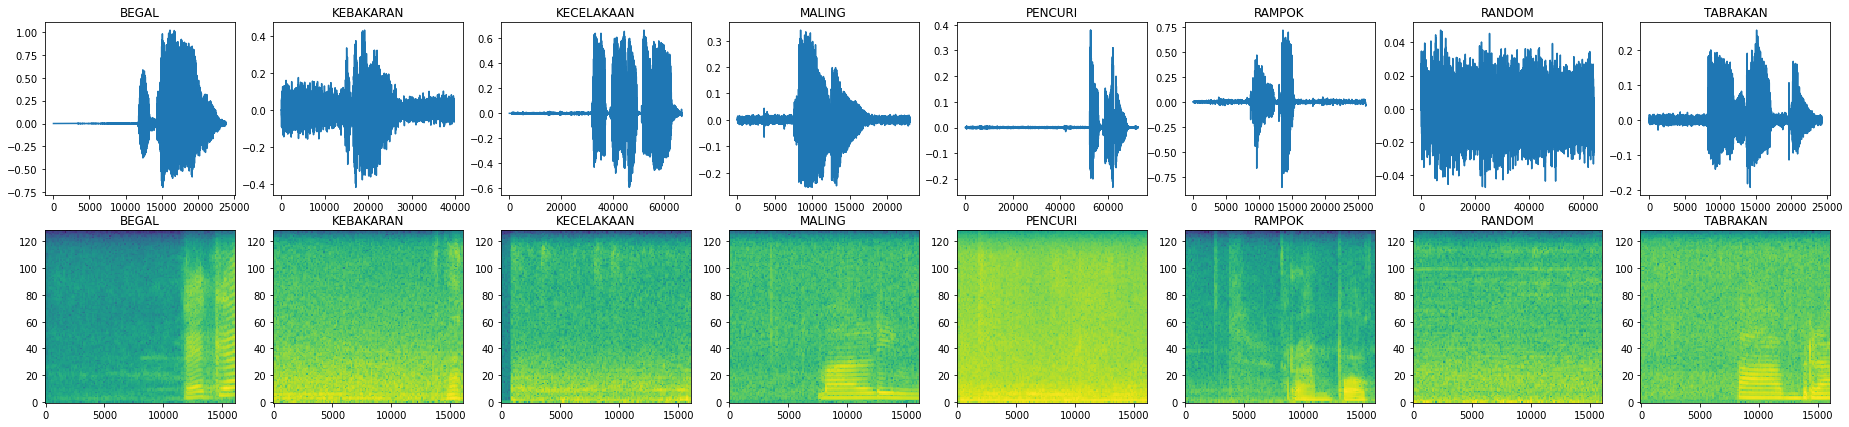

In [219]:
rows = 2
cols = 8
fig, ax = plt.subplots(rows, cols, figsize=(32, 7))
x = 0
y = 0

for e in event:
  waveform,label = _get_waveform_and_label(globals()[f"{e}_train"][0])
  label = label.numpy().decode('utf-8')
  ax[y,x].set_title(label)
  ax[y,x].plot(waveform.numpy())
  spec = _get_spectrogram(waveform)
  _plot_spectrogram(spec, ax[1][x])
  ax[1,x].set_title(label)
  x += 1

## Build Model

In [212]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=_get_waveform_and_label,
      num_parallel_calls=tf.data.AUTOTUNE)
  output_ds = output_ds.map(
      map_func=_get_spectrogram_and_label_id,
      num_parallel_calls=tf.data.AUTOTUNE)
  return output_ds

In [215]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val)
test_ds = preprocess_dataset(test)

In [216]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [217]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [85]:
#hyperparameter
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(event)

model = models.Sequential([
    Input(shape=input_shape),

    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(padding='same'),
    Dropout(0.25),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(padding='same'),
    Dropout(0.25),
    Flatten(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(num_labels, activation = 'softmax')])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 124, 129, 32)      320       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 62, 65, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 62, 65, 64)        18496     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 31, 33, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 31, 33, 128)       73856     
                                                                 
 max_pooling2d_64 (MaxPool

In [86]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

Epoch 1/20
29/29 [==============================] - 68s 2s/step - loss: 1.6687 - accuracy: 0.3999 - val_loss: 1.5813 - val_accuracy: 0.4242

In [87]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS,
)

Epoch 1/20
29/29 [==============================] - 71s 2s/step - loss: 1.6780 - accuracy: 0.3874 - val_loss: 1.5328 - val_accuracy: 0.4459
Epoch 2/20
29/29 [==============================] - 64s 2s/step - loss: 1.4629 - accuracy: 0.4573 - val_loss: 1.3981 - val_accuracy: 0.4848
Epoch 3/20
29/29 [==============================] - 74s 3s/step - loss: 1.3568 - accuracy: 0.4940 - val_loss: 1.2949 - val_accuracy: 0.5368
Epoch 4/20
29/29 [==============================] - 66s 2s/step - loss: 1.2711 - accuracy: 0.5233 - val_loss: 1.2055 - val_accuracy: 0.5498
Epoch 5/20
29/29 [==============================] - 69s 2s/step - loss: 1.1638 - accuracy: 0.5579 - val_loss: 1.1001 - val_accuracy: 0.5714
Epoch 6/20
29/29 [==============================] - 75s 3s/step - loss: 1.1062 - accuracy: 0.5887 - val_loss: 0.9679 - val_accuracy: 0.6407
Epoch 7/20
29/29 [==============================] - 87s 3s/step - loss: 0.9849 - accuracy: 0.6315 - val_loss: 0.8628 - val_accuracy: 0.7013
Epoch 8/20
29/29 [==

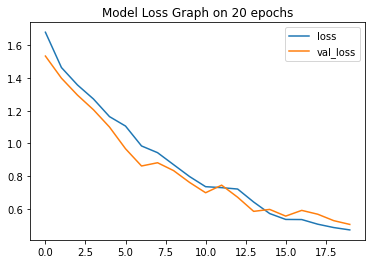

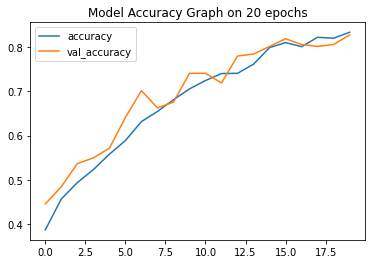

In [89]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(f'Model Loss Graph on {len(history.epoch)} epochs')
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title(f'Model Accuracy Graph on {len(history.epoch)} epochs')
plt.show()

### Test Dataset

In [125]:
test_audio = []
test_labels = []


for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [129]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 77%


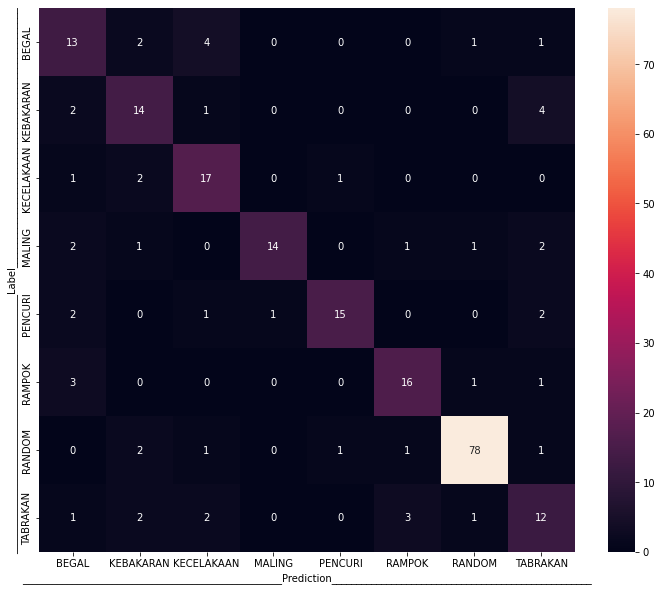

In [130]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mtx,
            xticklabels=event,
            yticklabels=event,
            annot=True, fmt='g')
plt.xlabel('____________________________________________________Prediction____________________________________________________')
plt.ylabel('____________________________________________________Label____________________________________________________')
plt.show()

## Save the model!

In [37]:
savedir='machine-learning/final-model'

In [134]:
model.save(savedir)

INFO:tensorflow:Assets written to: machine-learning/final-model\assets


In [38]:
loadedmodel = tf.keras.models.load_model(savedir)
loadedmodel.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 124, 129, 32)      320       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 62, 65, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 62, 65, 64)        18496     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 31, 33, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 31, 33, 128)       73856     
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 16, 17, 128)    

In [39]:
input_shape = [1,124,129]
def predicting(path):
  waveform = _decode_audio(path)
  spec = _get_spectrogram(waveform) 
  spec = tf.reshape(spec, input_shape)
  
  predict = list(loadedmodel.predict([spec])[0])
  print(f'Predict Probability : {predict}')
  
  predicted = max(predict)
  print(predicted)
  
  index = predict.index(predicted)
  predictresult = event[index]
  
  plt.figure(figsize=(12,5))
  plt.title(f"The audio {path} is predicted as {predictresult}")
  predictgraph(spec)
  display.display(display.Audio(waveform, rate=16000))

In [136]:
def predictgraph(spec):
    prediction = loadedmodel(spec)
    plt.bar(event, tf.nn.softmax(prediction[0]))
    plt.show()

tf.Tensor(44100, shape=(), dtype=int64)
Predict Probability : [5.6802546e-05, 1.2721685e-09, 2.969954e-10, 0.9998503, 9.288537e-05, 8.658894e-12, 7.637527e-12, 1.1953291e-12]
0.9998503


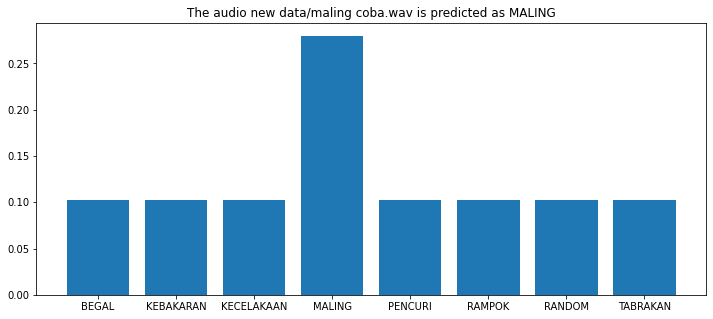

In [151]:
predicting('new data/maling coba.wav')

### **Creating TFLITE Model**

In [43]:
export_dir = 'machine-learning/final-model-tflite/'
tf.saved_model.save(loadedmodel,export_dir=export_dir)

INFO:tensorflow:Assets written to: machine-learning/final-model-tflite/assets


In [44]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [45]:
tflite_model_file = pathlib.Path(os.path.join('machine-learning','final-model.tflite'))
tflite_model_file.write_bytes(tflite_model)

1585600

### *Add metadata to tflite*

In [46]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [47]:
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "DANTION Audio Classification"
model_meta.description = ("Identify 7 event for emergency button "
                          "feature in DANTION app.")
model_meta.version = "v1.4"
model_meta.author = "C22-PS121 Bangkit Product Capstone Project Team"

In [48]:
input_meta = _metadata_fb.TensorMetadataT()
output_meta = _metadata_fb.TensorMetadataT()

In [50]:
input_meta.name = "Audio Input WAV"
input_meta.description = ("Input audio clip to be classified "
                          "(16 kHz float32 waveform samples in range -1.0..1.0).")
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.AudioPropertiesT()
input_meta.content.contentProperties.sampleRate = 16000
input_meta.content.contentProperties.channels = 1

input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType=(_metadata_fb.ProcessUnitOptions.NormalizationOptions)

input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [129]
input_stats.min = [0]
input_meta.stats = input_stats

In [57]:
output_meta.name = "classifier"
output_meta.description = ("Output probability for each event: "
                           "['BEGAL', 'KEBAKARAN', 'KECELAKAAN', 'MALING', 'PENCURI', 'RAMPOK', 'RANDOM', 'TABRAKAN']")

#Stats
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties
)

output_stats = _metadata_fb.StatsT()
output_stats.max= 1
output_stats.min= 0

#Crete Label File
event = ['BEGAL', 'KEBAKARAN', 'KECELAKAAN', 'MALING', 'PENCURI', 'RAMPOK', 'RANDOM', 'TABRAKAN']
pathtxt = 'machine-learning/final-model-label-file.txt'
with open(pathtxt,'w') as labelfile:
    for item in event:
        labelfile.write("%s\n" %item)

#Add label file
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(pathtxt)
label_file.description = "Label for audio classification that model can classify"
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [58]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [59]:
populator = _metadata.MetadataPopulator.with_model_file('machine-learning/final-model.tflite')
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([pathtxt])
populator.populate()

In [61]:
displayer = _metadata.MetadataDisplayer.with_model_file('machine-learning/final-model.tflite')
export_json_file = "machine-learning/final-model.json"
json_file = displayer.get_metadata_json()
# Optional: write out the metadata as a json file
with open(export_json_file, "w") as f:
  f.write(json_file)

# **Congratulation! 🎉**

Your model has been created, time to deploy it to android! 🤖